# Image Classification using Dense Neural Network
- This tutorial covers developing a DNN model to classify image data.
- Dataset used for analysis is FMNIST image dataset available in Tensflow's dataset repository.
- A multiclass classification DNN in `Tensorflow` framework is developed to identify 10 different classes of fashion items.
- Next step is to use `keras_tuner.RandomSearch` to tune the parameters used in the development of base DNN model and thus increase its performance.

In [1]:
# importing libraries necessary for data transformation, DNN development and tuning etc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

In [2]:
print(tf.__version__)
print(kt.__version__)

2.8.0
1.1.2


### I. Data Import and Pre-processing

In [3]:
# Load the Fashion MNIST dataset
df_mnist = tf.keras.datasets.fashion_mnist

In [4]:
# Split Fashion MNIST dataset into test and training dataset : X and Y/Target variables also defined
(X_train, Y_train), (X_test, Y_test) = df_mnist.load_data()

In [5]:
# Checking the dimensions of the datasets generated
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

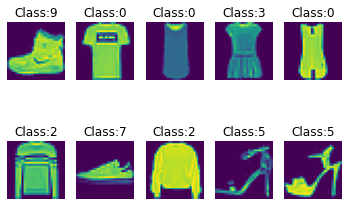

In [6]:
# Print first 10 elements/images with their corresponding label in the training dataset

for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title('Class:{}'.format(Y_train[i]))
    plt.axis('off')
    plt.grid(True)

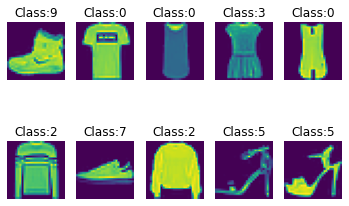

In [7]:
# normalizing images in train and test dataset and visualzie them again
X_train  = X_train / 255.0
X_test = X_test / 255.0

for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title('Class:{}'.format(Y_train[i]))
    plt.axis('off')
    plt.grid(True)

### II. Base DNN model development
- Building a baseline Dense Neural Network with 3 layers :
  - 64 units in Layer1
  - 64 units in Layer2
  - 10 units in Layer3 (Last layer has 10 units to classify 10 classes)

In [8]:
# clear state
tf.keras.backend.clear_session()
np.random.seed(21)

In [9]:
# develop base dnn
base_model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
                                         tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                         tf.keras.layers.Dense(64, activation='relu'), 
                                         tf.keras.layers.Dense(10, activation='softmax')])

# Assign model hyperparameters
base_model.compile(optimizer = tf.optimizers.Adam(),
                   loss = 'sparse_categorical_crossentropy',
                   metrics=['accuracy'])

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


In [10]:
# fit the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
base_model_history = base_model.fit(X_train, Y_train, validation_split=0.10,
                                    epochs=10, callbacks=[callback], batch_size=512)

Epoch 1/10
106/106 [==============================] - 3s 16ms/step - loss: 0.8097 - accuracy: 0.7262 - val_loss: 0.5018 - val_accuracy: 0.8197
Epoch 2/10
106/106 [==============================] - 1s 13ms/step - loss: 0.4732 - accuracy: 0.8346 - val_loss: 0.4534 - val_accuracy: 0.8323
Epoch 3/10
106/106 [==============================] - 1s 11ms/step - loss: 0.4208 - accuracy: 0.8532 - val_loss: 0.4142 - val_accuracy: 0.8535
Epoch 4/10
106/106 [==============================] - 1s 13ms/step - loss: 0.3932 - accuracy: 0.8628 - val_loss: 0.3936 - val_accuracy: 0.8595
Epoch 5/10
106/106 [==============================] - 1s 12ms/step - loss: 0.3741 - accuracy: 0.8686 - val_loss: 0.3845 - val_accuracy: 0.8665
Epoch 6/10
106/106 [==============================] - 1s 13ms/step - loss: 0.3591 - accuracy: 0.8736 - val_loss: 0.3642 - val_accuracy: 0.8692
Epoch 7/10
106/106 [==============================] - 1s 11ms/step - loss: 0.3462 - accuracy: 0.8758 - val_loss: 0.3626 - val_accuracy: 0.8672

In [11]:
print(base_model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


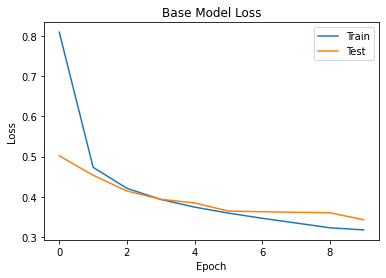

In [12]:
# summarize history for loss
plt.plot(base_model_history.history['loss'])
plt.plot(base_model_history.history['val_loss'])
plt.title('Base Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

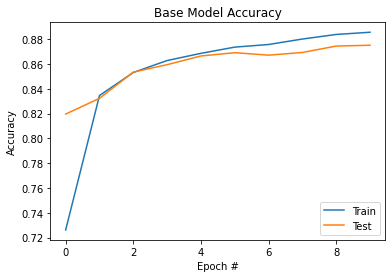

In [13]:
# summarize history for accuracy
plt.plot(base_model_history.history['accuracy'])
plt.plot(base_model_history.history['val_accuracy'])
plt.title('Base Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [14]:
# Evaluate the model on Test data
result_dictionary = base_model.evaluate(X_test, Y_test, return_dict=True, verbose=0)
base_model_performance = pd.DataFrame([result_dictionary.values()],
                                       columns=[list(result_dictionary.keys())])
base_model_performance['loss'] = round((base_model_performance['loss']),4)
base_model_performance['accuracy'] = round((base_model_performance['accuracy'])*100,2)
base_model_performance.index = ['Base_Model']   
print('Model performance on Test data')
print(base_model_performance)

Model performance on Test data
              loss accuracy
Base_Model  0.3671    87.13


### III. Hyperparameter Tuning

In [15]:
# define a tuner class with functions to build and fit a model with different combinations of hyperparamters

class MyHyperModel(kt.HyperModel):
  def build(self, hp):
      model = tf.keras.Sequential()
      model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
      
      for i in range(hp.Int('num_layers', 1, 5)):
          model.add(tf.keras.layers.Dense(units=hp.Choice('units_{}'.format(i),
                                                           values=[16, 32, 64, 128]),
                                                           activation='relu'))
          
      model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
      
      # Tune the learning rate for the optimizer
      # Choose an optimal value from 0.1, 0.01, 0.001, or 0.0001
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
      
      model.compile(optimizer=tf.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])
      return model 
  
  def fit(self, hp, model, *args, **kwargs):
    return model.fit(*args, batch_size=hp.Choice('batch_size', [128, 256, 512]), **kwargs, )

In [16]:
# create a tuner object to develop hyperparameter search space

tuner = kt.RandomSearch(MyHyperModel(),
                        objective='val_accuracy',
                        max_trials=16,
                        overwrite = True,
                        directory='my_dir',
                        project_name='tune_hypermodel')
tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}


In [17]:
tf.keras.backend.clear_session()
np.random.seed(21)

In [18]:
# fit tuner object on train data to find best model hyperparameter combination

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, Y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

Trial 16 Complete [00h 00m 10s]
val_accuracy: 0.10125000029802322

Best val_accuracy So Far: 0.8769999742507935
Total elapsed time: 00h 03m 34s
INFO:tensorflow:Oracle triggered exit


In [19]:
# Assigning best hyperparameters from the results
best_hpt=tuner.get_best_hyperparameters()[0]
print('Total Layers {}'.format(best_hpt.get('num_layers')+1))
print('Tuned Alpha {}'.format(best_hpt.get('learning_rate')))
print('Tuned Batch Size {}'.format(best_hpt.get('batch_size')))

Total Layers 5
Tuned Alpha 0.001
Tuned Batch Size 512


In [20]:
tuned_model = tuner.hypermodel.build(best_hpt)
tuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               100480    
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 16)                2064      
                                                                 
 dense_8 (Dense)             (None, 128)               2176      
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 122,522
Trainable params: 122,522
Non-tr

In [21]:
# clear states
tf.keras.backend.clear_session()
np.random.seed(21)

# fit the tuned model
tuned_model_history = tuned_model.fit(X_train, Y_train, epochs=10, validation_split=0.2,
                                      batch_size=best_hpt.get('batch_size'),
                                      callbacks=[stop_early], verbose=2)

Epoch 1/10
94/94 - 2s - loss: 0.9104 - accuracy: 0.6820 - val_loss: 0.5273 - val_accuracy: 0.8055 - 2s/epoch - 18ms/step
Epoch 2/10
94/94 - 1s - loss: 0.4797 - accuracy: 0.8299 - val_loss: 0.4476 - val_accuracy: 0.8413 - 997ms/epoch - 11ms/step
Epoch 3/10
94/94 - 1s - loss: 0.4178 - accuracy: 0.8500 - val_loss: 0.4056 - val_accuracy: 0.8569 - 980ms/epoch - 10ms/step
Epoch 4/10
94/94 - 1s - loss: 0.3840 - accuracy: 0.8621 - val_loss: 0.4030 - val_accuracy: 0.8547 - 967ms/epoch - 10ms/step
Epoch 5/10
94/94 - 1s - loss: 0.3564 - accuracy: 0.8720 - val_loss: 0.3767 - val_accuracy: 0.8666 - 975ms/epoch - 10ms/step
Epoch 6/10
94/94 - 1s - loss: 0.3442 - accuracy: 0.8744 - val_loss: 0.3558 - val_accuracy: 0.8719 - 997ms/epoch - 11ms/step
Epoch 7/10
94/94 - 1s - loss: 0.3243 - accuracy: 0.8823 - val_loss: 0.3536 - val_accuracy: 0.8711 - 989ms/epoch - 11ms/step
Epoch 8/10
94/94 - 1s - loss: 0.3098 - accuracy: 0.8876 - val_loss: 0.3441 - val_accuracy: 0.8793 - 958ms/epoch - 10ms/step
Epoch 9/10


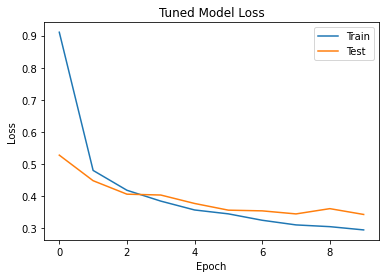

In [22]:
# summarize history for loss
plt.plot(tuned_model_history.history['loss'])
plt.plot(tuned_model_history.history['val_loss'])
plt.title('Tuned Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

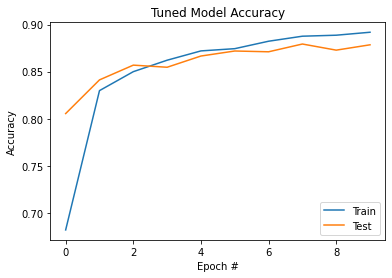

In [23]:
# summarize history for accuracy
plt.plot(tuned_model_history.history['accuracy'])
plt.plot(tuned_model_history.history['val_accuracy'])
plt.title('Tuned Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [24]:
# Evaluate the model on Test data
result_dictionary = tuned_model.evaluate(X_test, Y_test, return_dict=True, verbose=0)
tuned_model_performance = pd.DataFrame([result_dictionary.values()],
                                        columns=[list(result_dictionary.keys())])
tuned_model_performance['loss'] = round((tuned_model_performance['loss']),4)
tuned_model_performance['accuracy'] = round((tuned_model_performance['accuracy'])*100,2)
tuned_model_performance.index = ['Tuned_Model']   
tuned_model_performance

,loss,accuracy
Tuned_Model,0.3617,87.3
